In [8]:
import sys
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# %matplotlib ipympl
# %matplotlib inline
%matplotlib widget

In [9]:
# Local
cwd = pathlib.Path().resolve()
src = cwd.parent
root = src.parent
sys.path.append(str(src))
sys.path.append(str(root))

from utils.watertopo import WaterTopo
from utils.simulation import Simulation
from utils.utils import count_parameters, mse_per_timestep, recursive_pred
from utils.plot import compare_simulations_slider

from models.unet_source import UNet_source
from models.unet import UNet
from models.unet_mask import UNet_mask


In [10]:
#initialize GPU -  In case of windows use cuda instead of nps
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Is CUDA enabled?",torch.cuda.is_available())
print("Number of GPUs",torch.cuda.device_count())

Is CUDA enabled? False
Number of GPUs 0


In [11]:
# Initialize the model

best_model = UNet_mask(2, [32, 64], 1, 5)

# Load the parameters from training
load_path = "../results/trained_models/unet_mask/"

best_model.load_state_dict(torch.load(load_path + "unet_32_64_orig_data80_skip5_hardmask5", map_location="cpu"))
best_model.eval()

UNet_mask(
  (encoder): Encoder(
    (in_layer): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (enc_blocks): ModuleList(
      (0): Down(
        (maxpool_conv): Sequential(
          (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (1): DoubleConv(
            (double_conv): Sequential(
              (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(in

In [12]:
# Load two other models for comparison
load_path = "../results/trained_models/unet/"

# U-Net source with timeskip 5
unet_source = UNet_source(2, 1)
unet_source.load_state_dict(torch.load(load_path + "unet_source_orig_skip5", map_location="cpu"))
unet_source.eval()

# U-Net 32, 64, 128 with timeskip 5
unet = UNet(2, [32, 64, 128], 1)
unet.load_state_dict(torch.load(load_path + "unet_32_64_128_orig_data80_skip5", map_location="cpu"))
unet.eval()

models = [best_model, unet_source, unet]

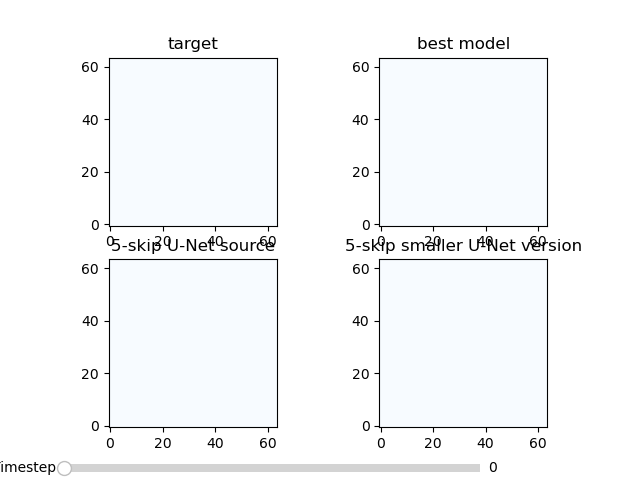

C:\Users\pjdeb\AppData\Local\Temp\ipykernel_20288\2999712542.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [16]:
skips = [5, 5, 5]
labels = ["target", "best model", "5-skip U-Net source", "5-skip smaller U-Net version"]
grid_size = 64

sim = WaterTopo.load_simulations(str(root)+"/data/normalized_data/test1", 
                                 1, grid_size, 
                                 use_augmented_data=True)[0]

topo = sim.topography.reshape([1, grid_size, grid_size])
wd_0 = sim.wd[0].reshape([1, grid_size, grid_size])
X = np.concatenate([topo, wd_0])

wds = []
wds.append(sim.wd)

with torch.no_grad():
    shortest_wd = np.inf

    for i in range(len(models)):
        skip = skips[i]

        if skips:
            sim_skips = sim.implement_skips(skip)

        outputs = recursive_pred(models[i], X, sim_skips.wd.shape[0]-1, include_first_timestep=True)
        wds.append(outputs.detach().numpy())

    slider1 = compare_simulations_slider(wds, labels)
plt.tight_layout()

In [21]:
# Load the augment versions of the models
load_path = "../results/trained_models/unet/"

# U-Net source with timeskip 5
unet_source = UNet_source(2, 1)
unet_source.load_state_dict(torch.load(load_path + "unet_source_aug_skip5", map_location="cpu"))
unet_source.eval()

# U-Net 32, 64, 128 with timeskip 5
unet = UNet(2, [32, 64], 1)
unet.load_state_dict(torch.load(load_path + "unet_32_64_aug_data80_skip5", map_location="cpu"))
unet.eval()

models = [best_model, unet_source, unet]

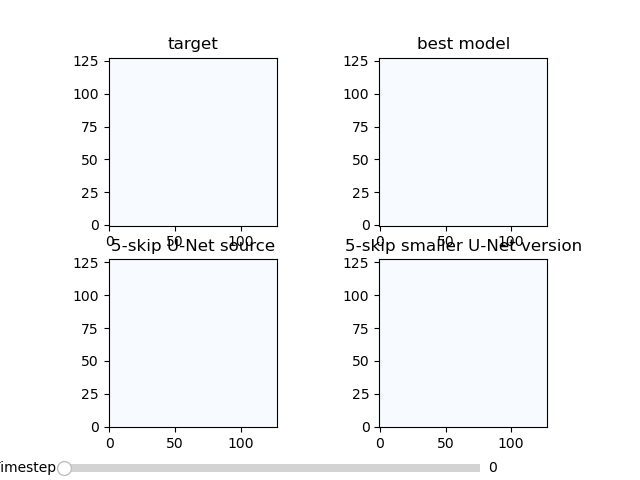

C:\Users\pjdeb\AppData\Local\Temp\ipykernel_20288\3046619314.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [22]:
skips = [5, 5, 5]
labels = ["target", "best model", "5-skip U-Net source", "5-skip smaller U-Net version"]
grid_size = 128

sim = WaterTopo.load_simulations(str(root)+"/data/normalized_data/test3", 
                                 1, grid_size, 
                                 use_augmented_data=True)[0]

topo = sim.topography.reshape([1, grid_size, grid_size])
wd_0 = sim.wd[0].reshape([1, grid_size, grid_size])
X = np.concatenate([topo, wd_0])

wds = []
wds.append(sim.wd)

with torch.no_grad():
    shortest_wd = np.inf

    for i in range(len(models)):
        skip = skips[i]

        if skips:
            sim_skips = sim.implement_skips(skip)

        outputs = recursive_pred(models[i], X, sim_skips.wd.shape[0]-1, include_first_timestep=True)
        wds.append(outputs.detach().numpy())

    slider1 = compare_simulations_slider(wds, labels)
plt.tight_layout()